# Model Explanations with Shapley Values:
Shapley values can be computed within DMLC XGBOOST (https://medium.com/rapids-ai/gpu-accelerated-shap-values-with-xgboost-1-3-and-rapids-587fad6822). 

Comment on file size of exported model. 5-depth: 3MB, 10-depth: 52MB, 15-depth: 113MB.

- quadratic/nonlinear complexity with increasing max_depth. Show this.
- linear complexity with more classes. Show this?


In [1]:
import os
import sys
import re
import json
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from time import time
from functools import reduce

# import matplotlib.pyplot as plt
import bokeh as bk
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
output_notebook()

import dask
import dask.dataframe as dd
import dask.bag as db
from dask.distributed import Client, progress
from datetime import datetime

import shap
import sklearn
import xgboost as xgb


max_depth = 15
run_type = 'gpu' # Select 'cpu' or 'gpu'
compute_strategy = 'node' # Select 'node' or 'cluster'. Data larger than single GPU requires 'cluster' compute_strategy.

study_arpt = 'NAS'

if study_arpt == 'NAS':
    # NAS processing excludes weather. Has additional cols for arrival/departure airports.
    pred_model = 'multi_class'
    label_col = 'DELAY_CAUSES_ENC'
    delay_causes_cols = ['LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY', 'NAS_DELAY', 'OTHER_DELAY']
    excluded_features = [label_col, 'cv_idx', 'class_weight', 'UID', 'ARR_DEL15', 'DEP_DEL15']
    target_encode_cols = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'OD_PAIR', 'HOLIDAY_NAME', 'TAIL_NUM', 
                          'ORIGIN_HourlyPresentWeatherTypeCombo', 'DEST_HourlyPresentWeatherTypeCombo']
else:
    pred_model = 'binary_class'
    label_col = 'ARR_DEL15'
    excluded_features = [label_col, 'cv_idx', 'UID', 'DEL_ARR_PER_QTHR', 'DEL_DEP_PER_QTHR', 'DEP_DEL15']
    target_encode_cols = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'HOLIDAY_NAME', 'HourlyPresentWeatherTypeCombo']

enc_output_dir = './data/encoded/split/'+study_arpt+'/test' # Can compute Shapley values off of test data.
# model_file = 'xgb_'+run_type+'_airline_delay_'+study_arpt
model_file = 'xgb_'+run_type+'_airline_delay_'+study_arpt+'_max_depth_'+str(max_depth) # Only CPU model ran successfully. Need more than 16GB VRAM or gpu cluster to complete.

# client = Client('tcp://192.168.1.232:8786')

if run_type == 'gpu':
    from dask_cuda import LocalCUDACluster
    
    cluster = LocalCUDACluster(threads_per_worker=16, memory_limit='128GB')
    client = Client(cluster)
#     client = Client(n_workers=1, threads_per_worker=32)
elif run_type == 'cpu':
#     client = Client(n_workers=1, threads_per_worker=32)
    client = Client(n_workers=2, threads_per_worker=16, memory_limit='128GB')
    
client

Loading BokehJS ...

Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38255 instead
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:38255/status,
Dashboard: http://127.0.0.1:38255/status,Workers: 2
Total threads: 32,Total memory: 238.42 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44563,Workers: 2
Dashboard: http://127.0.0.1:38255/status,Total threads: 32
Started: Just now,Total memory: 238.42 GiB
Comm: tcp://127.0.0.1:41769,Total threads: 16
Dashboard: http://127.0.0.1:37523/status,Memory: 119.21 GiB
Nanny: tcp://127.0.0.1:41085,


In [2]:
if compute_strategy == 'node':
    if run_type == 'gpu':
        import cudf as hw
    else:
        import pandas as hw
elif compute_strategy == 'cluster':
    if run_type == 'gpu':
        import dask_cudf as hw
    else:
        import dask.dataframe as hw
    
# Run predictions:
method = 'xgb_' + run_type
data_path = enc_output_dir
model = xgb.Booster(model_file=model_file+'.model')
model.set_param('predictor', run_type+'_predictor')
# model = client.scatter(model, broadcast=True) # Pre scattering model can improve performance

tic = time()
if (method == 'xgb_gpu') | (method == 'xgb_cpu'):
    method_type = method.split('_')[1]
    
    ddf_enc = hw.read_parquet(data_path).sample(frac=0.1, random_state=0)
#     ddf_enc = hw.read_parquet(data_path).iloc[:int(7E4)]
    print('Number of records in input data:', len(ddf_enc))
    
    # Format data for xgboost training:
    feature_cols = [cc for cc in ddf_enc.columns if cc not in excluded_features]
#     print(feature_cols)
    
    # Update bool cols:
    bool_cols = list(ddf_enc.select_dtypes(bool).columns)
    ddf_enc[bool_cols] = ddf_enc[bool_cols].astype('int8')
    
    X = ddf_enc[feature_cols].astype('float32')
    y = ddf_enc[label_col].astype('float32')

    if compute_strategy == 'node':
        shap_values = model.predict(xgb.DMatrix(X, y), pred_contribs=True)
    elif compute_strategy == 'cluster':
        shap_values = xgb.dask.predict(client, model, xgb.dask.DaskDMatrix(client, X, y), pred_contribs=True)

        # IMPORTANT: X.values required to get consistent CPU scoring. Issue with column ordering in dask.dataframe?
#         shap_values = xgb.dask.predict(client, model, X.values, pred_contribs=True) # Use pred_contribs not available in inplace_predict()
        
        shap_values = shap_values.compute()
        
    # Some cols are removed during model encoding and/or feature engineering. 
    print('Shape of shap_values:', shap_values.shape)
    print('Number of features:', len(feature_cols))

if pred_model == 'binary_class':
    shap_expected_values = shap_values[:,-1]
    shap_values = shap_values[:,:-1]
elif pred_model == 'multi_class':
    shap_expected_values = shap_values[:,:,-1]
    shap_values = shap_values[:,:,:-1]


# Note that XGB shap computation has an extra column appended. "The last column in the output shap_values contains the ‘bias’ or the expected output of the model if no features were used."
# Since we will be using the python shap package to visualize results, it's safe to drop the last column for compatibility.
# pred_contribs (bool) – When this is True the output will be a matrix of size (nsample, nfeats + 1) with each record indicating the feature contributions (SHAP values) for that prediction. 
# The sum of all feature contributions is equal to the raw untransformed margin value of the prediction. Note the final column is the bias term.

print('xgboost shap_values computation time:', '{:0.2f}'.format(time() - tic) + 's')


# Shapley value for multi-class problem uses a lot of mem. Maybe it's running all classes simultaneously with copies of the data?
# Much more expensive to compute for deep tree models. 

# Use training set and randomly sample 70k (frac=0.01) or 700k (frac=0.1) records:
# 70k samples on 1x RTX8000 GPU: 5-depth took 8s, 10-depth took 76s, 15-depth took 195s.
# 700k samples on 1x RTX8000 GPU: 5-depth took 23s, 10-depth took 589s, 15-depth took 1647s.
# 700k samples on 2x RTX8000 GPU: 5-depth took 15s, 10-depth took 311s, 15-depth took 856s.

# 70k samples on 32-core CPU: 5-depth took 15s, 10-depth took 395s, 15-depth took 1100.77s.
# 700k samples on 32-core CPU: 5-depth took 91s, 10-depth took 3879s, 15-depth took ---.

# TODO: MNMG wrapper for multi-class shapley value cuml.explainer.PermutationExplainer (based on SHAP Kernel Explainer). Use dask.predict() for now.
# Need One-vs-One training implementation to reduce memory usage and compute during training and shapley value computation. 



Number of records in input data: 21822
Shape of shap_values: (21822, 9, 141)
Number of features: 140
xgboost shap_values computation time: 16.17s


In [3]:
# Convert dask.dataframe, cudf, etc. to pandas:
if compute_strategy == 'node':
    if run_type == 'gpu':
        pd_enc = ddf_enc.to_pandas()
    else:
        pd_enc = ddf_enc
elif compute_strategy == 'cluster':
    if run_type == 'gpu':
        pd_enc = ddf_enc.compute().to_pandas()
    else:
        pd_enc = ddf_enc.compute()
        
X_cmp = pd_enc[feature_cols]
y_cmp = pd_enc[label_col]

In [4]:
# Consolidate labels into broader categories:
wx_attr = ['HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlyPressureChange', 'HourlyVisibility',
           'HourlyWindDirection_sin', 'HourlyWindDirection_cos', 
           'HourlyWindGustSpeed', 'HourlyWindSpeed', 'HourlySkyCover_BKN', 'HourlySkyCover_FEW', 'HourlySkyCover_OVC',
           'HourlySkyCover_SCT', 'HourlySkyCover_VV', 'HourlyPresentWeatherTypeCombo']
wx_attr = [prefix+cc for prefix in ['ORIGIN_', 'DEST_'] for cc in wx_attr]

seasons_attr = ['QUARTER', 'MONTH', 'DAY_OF_YEAR', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME_HR', 
                'CRS_DEP_TIME_QTHR', 'CRS_ARR_TIME_HR', 'CRS_ARR_TIME_QTHR']
seasons_attr = [cc+suffix for suffix in ['_sin', '_cos'] for cc in seasons_attr] + ['YEAR', 'HOLIDAY_NAME', 'IS_HOLIDAY', 'IS_WEEKEND']

combine_labels = {
    'ARPT_ATTR': [cc for cc in feature_cols if cc.find('ARPT')!=-1],
    'SEASON_ATTR': seasons_attr,
    'DEMAND_ATTR': ['ORIGIN_ARR_PER_QTHR', 'ORIGIN_CRS_ARR_PER_QTHR', 'ORIGIN_DEL_ARR_PER_QTHR', 'ORIGIN_ARR_DIFF0_PER_QTHR', 
                    'ORIGIN_ARR_PER_QTHR_LAG30', 'ORIGIN_CRS_ARR_PER_QTHR_LAG30', 'ORIGIN_DEL_ARR_PER_QTHR_LAG30', 
                    'ORIGIN_ARR_DIFF0_PER_QTHR_LAG30', 'ORIGIN_ARR_PER_QTHR_LAG15', 'ORIGIN_CRS_ARR_PER_QTHR_LAG15', 
                    'ORIGIN_DEL_ARR_PER_QTHR_LAG15', 'ORIGIN_ARR_DIFF0_PER_QTHR_LAG15', 'ORIGIN_CRS_ARR_PER_QTHR_LEAD15', 
                    'ORIGIN_CRS_ARR_PER_QTHR_LEAD30', 'ORIGIN_ARR_DIFF1_PER_QTHR', 'ORIGIN_ARR_DIFF2_PER_QTHR', 'ORIGIN_DEP_PER_QTHR', 
                    'ORIGIN_CRS_DEP_PER_QTHR', 'ORIGIN_DEL_DEP_PER_QTHR', 'ORIGIN_DEP_DIFF0_PER_QTHR', 'ORIGIN_DEP_PER_QTHR_LAG30', 
                    'ORIGIN_CRS_DEP_PER_QTHR_LAG30', 'ORIGIN_DEL_DEP_PER_QTHR_LAG30', 'ORIGIN_DEP_DIFF0_PER_QTHR_LAG30', 
                    'ORIGIN_DEP_PER_QTHR_LAG15', 'ORIGIN_CRS_DEP_PER_QTHR_LAG15', 'ORIGIN_DEL_DEP_PER_QTHR_LAG15', 
                    'ORIGIN_DEP_DIFF0_PER_QTHR_LAG15', 'ORIGIN_CRS_DEP_PER_QTHR_LEAD15', 'ORIGIN_CRS_DEP_PER_QTHR_LEAD30', 
                    'ORIGIN_DEP_DIFF1_PER_QTHR', 'ORIGIN_DEP_DIFF2_PER_QTHR', 'DEST_ARR_PER_QTHR', 'DEST_CRS_ARR_PER_QTHR', 
                    'DEST_DEL_ARR_PER_QTHR', 'DEST_ARR_DIFF0_PER_QTHR', 'DEST_ARR_PER_QTHR_LAG30', 'DEST_CRS_ARR_PER_QTHR_LAG30', 
                    'DEST_DEL_ARR_PER_QTHR_LAG30', 'DEST_ARR_DIFF0_PER_QTHR_LAG30', 'DEST_ARR_PER_QTHR_LAG15', 
                    'DEST_CRS_ARR_PER_QTHR_LAG15', 'DEST_DEL_ARR_PER_QTHR_LAG15', 'DEST_ARR_DIFF0_PER_QTHR_LAG15', 
                    'DEST_CRS_ARR_PER_QTHR_LEAD15', 'DEST_CRS_ARR_PER_QTHR_LEAD30', 'DEST_ARR_DIFF1_PER_QTHR', 
                    'DEST_ARR_DIFF2_PER_QTHR', 'DEST_DEP_PER_QTHR', 'DEST_CRS_DEP_PER_QTHR', 'DEST_DEL_DEP_PER_QTHR', 
                    'DEST_DEP_DIFF0_PER_QTHR', 'DEST_DEP_PER_QTHR_LAG30', 'DEST_CRS_DEP_PER_QTHR_LAG30', 
                    'DEST_DEL_DEP_PER_QTHR_LAG30', 'DEST_DEP_DIFF0_PER_QTHR_LAG30', 'DEST_DEP_PER_QTHR_LAG15', 
                    'DEST_CRS_DEP_PER_QTHR_LAG15', 'DEST_DEL_DEP_PER_QTHR_LAG15', 'DEST_DEP_DIFF0_PER_QTHR_LAG15', 
                    'DEST_CRS_DEP_PER_QTHR_LEAD15', 'DEST_CRS_DEP_PER_QTHR_LEAD30', 'DEST_DEP_DIFF1_PER_QTHR', 'DEST_DEP_DIFF2_PER_QTHR'],
    'WEATHER_ATTR': wx_attr
}

In [5]:
max_display = 11
combine_attr = True # Combine features to decrease number of attributes

# Load class labels:
num_classes = int(np.max(y)+1)
meta_class_cnts = pd.read_csv('./data/staging_tbl/class_labels.csv')

# Truncate at last class:
meta_class_cnts = meta_class_cnts[:num_classes]
class_labels = list(meta_class_cnts['CLASS_STR'].values)
class_labels = class_labels[:-1] + ['OOOO']


shap_imp_by_class = pd.DataFrame(np.abs(shap_values).mean(axis=0), columns=feature_cols)
# shap_imp_by_class['CLASS'] = ['CLASS_' + str(ii) for ii in range(shap_values.shape[1])]
shap_imp_by_class['CLASS'] = class_labels
shap_imp_by_class = shap_imp_by_class.set_index('CLASS')

if combine_attr == True:
    # Use combine_labels to combine Shapley values for each attribute group.
    combine_labels_vals = reduce(lambda x,y: x+y, list(combine_labels.values()))
    remaining_cols = list(set(feature_cols) - set(combine_labels_vals))
    shap_imp_combo_attr = shap_imp_by_class[remaining_cols].copy()

    for kk in combine_labels.keys():
        shap_imp_combo_attr.loc[:, kk] = shap_imp_by_class[combine_labels[kk]].sum(axis=1).values
        
    shap_imp_by_class = shap_imp_combo_attr

    
sorted_feature_imp = list(shap_imp_by_class.sum().sort_values(ascending=False).index)

shap_imp_by_class = shap_imp_by_class[sorted_feature_imp].reset_index()
shap_imp_by_class

,CLASS,DEP_DELAY,ARR_DELAY,DEMAND_ATTR,SEASON_ATTR,WEATHER_ATTR,OP_UNIQUE_CARRIER,TAXI_OUT,ARPT_ATTR,OD_PAIR,TAIL_NUM,ACTUAL_ELAPSED_TIME,CRS_ELAPSED_TIME,TAXI_IN,ORIGIN,DEST,AIR_TIME,DISTANCE,DISTANCE_GROUP
0,----,0.015600,10.510444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-C--,2.748770,0.939932,0.563349,0.368560,0.298748,0.474728,0.083736,0.151737,0.297403,0.281556,0.029184,0.031725,0.031222,0.035677,0.023440,0.013256,0.009246,0.000064
2,--N-,2.066218,4.373202,0.475890,0.414943,0.270132,0.430254,0.050615,0.136138,0.049633,0.166690,0.014316,0.008500,0.051034,0.027824,0.062964,0.016892,0.024247,0.000066
3,-CN-,2.292043,1.721203,0.471229,0.157542,0.233293,0.126171,0.158996,0.133163,0.050324,0.050489,0.274974,0.135911,0.010670,0.010094,0.017593,0.052686,0.010252,0.000100
4,L---,3.704992,0.173931,0.942374,0.262014,0.277974,0.426349,0.175667,0.145199,0.036013,0.093417,0.158989,0.068493,0.028730,0.027365,0.032740,0.027502,0.021975,0.000389
5,LC--,4.582729,0.210923,0.528354,0.347477,0.255704,0.352231,0.199344,0.109991,0.071278,0.084373,0.062273,0.049185,0.033191,0.020552,0.022838,0.017695,0.024140,0.000737
6,L-N-,1.906232,0.478800,1.008176,0.504989,0.363860,0.184888,0.276566,0.164085,0.108359,0.126395,0.157922,0.095515,0.099266,0.019972,0.033714,0.039708,0.029527,0.000513
7,LCN-,1.893338,0.607091,0.811206,0.501300,0.325494,0.367035,0.158291,0.182696,0.252734,0.140769,0.206784,0.071910,0.077290,0.037312,0.018806,0.023828,0.031052,0.000270
8,OOOO,1.441631,0.546569,0.775618,0.438622,0.951999,0.200607,0.272757,0.209801,0.252851,0.100858,0.015053,0.012969,0.020121,0.104416,0.042533,0.012712,0.014660,0.000229


In [6]:
from bokeh.models import Legend

p = figure(plot_height=500, plot_width=800, y_range=list(shap_imp_by_class['CLASS']), x_range=(0,18), 
            title='Shapley Global Feature Importance', 
           toolbar_location=None, tools='hover', tooltips='$name: @$name'
           )

# TODO: more granular ranking within each class, then get rank overall. Some ideas: https://towardsdatascience.com/rank-the-features-now-rank-again-4dafd8cde3c8
# Within each class, rank features by order of Shapley importance. Then sum results overall to get ranking as a whole for plotting.
# rank_class_ii = shap_imp_by_class.loc[5, feature_cols].sort_values(ascending=False)
# Plot each column separately so that features can be plotted by rank?

# Pick top (max_dislay-1) features based on overall ranking for now.
feature_subset = sorted_feature_imp[:max_display-1]
other_features = list(set(list(shap_imp_by_class.columns.difference(['CLASS']))) - set(feature_subset))

# Create an "OTHER" column to consolidate remaining features:
shap_imp_by_class_sm = shap_imp_by_class[['CLASS']+feature_subset].copy()
shap_imp_by_class_sm['OTHER'] = shap_imp_by_class[other_features].sum(axis=1)

p.hbar_stack(feature_subset+['OTHER'], y='CLASS', height=0.9, 
             color=bk.palettes.Category20[max_display], source=shap_imp_by_class_sm,
             legend_label=feature_subset+['OTHER']
            )

p.xaxis.axis_label = 'mean(|SHAP value|)'
p.add_layout(Legend(), 'below')
# p.add_layout(Legend(), 'left')
# p.legend.location = 'top_left'
p.legend.click_policy = 'hide'

# Legend location with bokeh hbar_stack not being positioned outside plot. Use x_range option for now.

# TODO: replace CLASS with bitstring, then bitstring with letter code (e.g., 1010 as LN for LATE_AIRCRAFT_DELAY & NAS_DELAY)?
show(p)

In [7]:
# Possible use case: embedding Shapley values, dimensionality reduction, clustering
# Ranking can get complicated: https://towardsdatascience.com/rank-the-features-now-rank-again-4dafd8cde3c8.
# Use cross-validation to examine feature importance across folds. Check for stability, and help with feature down-selection/generalize model.
# Basically a guided search of the feature-space rather than randomly permutting features to see what works well.

In [8]:
%%time

# # Compute shap values using shap package and externally trained model:
# explainer = shap.Explainer(model) # Including X as second arg forces shap to recompute it. May result in different shap values since new model generated.
# shap_exp_obj = explainer(X_cmp)


# shap package explainer class uses attributes like .values (shap_values), .base_values 
# (shap_expected_values), and .data (X, feature matrix). Should reuse them to make xgb computation compatible.

# Create shap explainer object:
explainer = shap.TreeExplainer(model)
shap_exp_obj = explainer(X_cmp.iloc[:2,]) # Construct as place holder class from 2 rows of data.

# Populate Explainer object with shap attributes computed from xgb.
shap_exp_obj.values = shap_values
shap_exp_obj.base_values = shap_expected_values
shap_exp_obj.data = X_cmp.values

# # Clean up:
# del shap_values, shap_expected_values

CPU times: user 16.3 s, sys: 468 ms, total: 16.8 s
Wall time: 8.16 s


In [9]:
# shap python package has more extensive visualization capabilities built-in. But it doesn't recognize dask/cudf dataframes.
# Gather dask dataframes to pandas after using dask+xgb to distributively compute shap_values. 

# load JS visualization code to notebook
shap.initjs()

# Examine explanation for single observation:
row_num = 11
class_num = 8

print('Actual class:', class_labels[y_cmp.iloc[row_num]])

# shap.force_plot(explainer.expected_value, py_shap_values[row_num,:], X_pd.iloc[row_num,:]) # Shap values from pandas + shap package
# shap.force_plot(shap_expected_values[row_num], shap_values[row_num,:], X_cmp.iloc[row_num,:]) # Shap values from dask + xgb package

# shap.force_plot() with multi-class stacked bar-chart styling.

# for class_num in range(num_classes):
print('Force plot for class:', class_labels[class_num])

# Use link='logit' to obtain probability scaling on force_plot
shap.plots.force(explainer.expected_value[class_num], shap_exp_obj.values[row_num][class_num], X_cmp.iloc[row_num,:], feature_names=feature_cols, link='logit')

# shap values add up to logit instead of probab [0 <= y_pred <=1]. 

# TODO: iterate through each class to plot individual class force_plot in pred_model='multi_class' case.

Actual class: ----
Force plot for class: OOOO


In [10]:
# Balanced sampling based on label:
from sklearn.model_selection import train_test_split

n_samples = 500
train_idx, test_idx = train_test_split(np.arange(len(pd_enc)), train_size=n_samples/len(pd_enc), stratify=pd_enc[label_col], random_state=0)

not enough data in bin #5 for feature ORIGIN_DEL_DEP_PER_QTHR, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #7 for feature ORIGIN_DEL_DEP_PER_QTHR, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #6 for feature ORIGIN_DEL_DEP_PER_QTHR_LAG15, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #7 for feature ORIGIN_DEL_DEP_PER_QTHR_LAG15, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #0 for feature DEST_HourlyVisibility, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #1 for feature DEST_HourlyVisibility, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #2 for feature DEST_HourlyVisibility, so it'll be ignored. Try increasing the number of records to plot.
not enough data in bin #7 for feature DEST_HourlyVisibility, so it'll be ignored. Tr

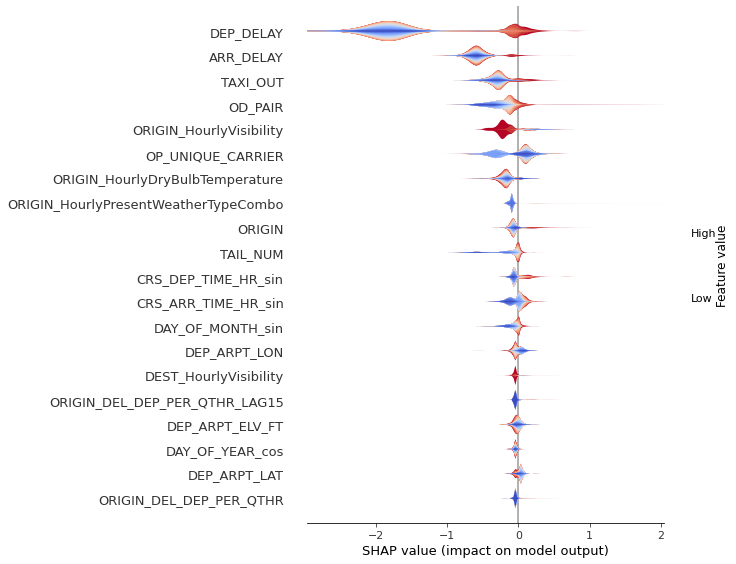

In [11]:
# Density plot for n_samples:
sel_class = 8 # 

if pred_model == 'multi_class':
    shap_value_slice = shap_values[train_idx,sel_class,:]
else:
    shap_value_slice = shap_values[train_idx,:]

shap.summary_plot(shap_value_slice, features=X_cmp.iloc[train_idx,:], plot_type='layered_violin')

In [12]:
from sklearn.metrics import roc_auc_score, accuracy_score

# Convert logit from "raw" output of shap_values to probabilities:
y_logit = shap_values.sum(axis=1) + shap_expected_values
y_odds = np.exp(y_logit)
y_proba = y_odds / (1 + y_odds)

# Combine prediction results:
pred_df = pd.DataFrame({'y_true': y_cmp.values, 'y_proba': y_proba, 'y_round': np.round(y_proba)})
pred_df['misclassified'] = pred_df['y_true'] != pred_df['y_round']

# Identify mis-classifications:
misclassified = pred_df[pred_df['misclassified'] == True]
print('Accuracy score:', 1-len(misclassified)/len(pred_df))
print('Number of records misclassified:', len(misclassified))

# Note that AUC score is different than that obtained during inference directly. We computed the probability from adding the "raw" values and converting. 
print('AUC score:', roc_auc_score(pred_df.y_true, pred_df.y_round))
pred_df

ValueError: operands could not be broadcast together with shapes (21822,140) (21822,9) 

In [ ]:
# Select N_display_samp from each labelled class for further visualization:
N_display_samp = 100
pd_enc_sample = pd_enc.groupby(label_col).head(N_display_samp)
display_samp_idx = list(pd_enc_sample.index)

# SHAP decision plot: https://slundberg.github.io/shap/notebooks/plots/decision_plot.html
# link='logit' shows probabilities on top.
shap.decision_plot(shap_expected_values[0], shap_values[display_samp_idx,:], features=X_cmp.iloc[display_samp_idx,:], link='logit', 
                   feature_display_range=slice(None, None, -1))

In [ ]:
# Use feature_order='hclust' to spot outliers more easily. Avoid using link='logit' when trying to spot outliers.
shap.decision_plot(shap_expected_values[0], shap_values[display_samp_idx,:], features=X_cmp.iloc[display_samp_idx,:], 
                   feature_display_range=slice(None, None, -1), feature_order='hclust') 

In [ ]:
# Apply clustering to identify customer segments and personas. Unsupervised method limited to DBSCAN and UMAP on GPU atm. 
# Need to reduce the 40 dim data down to a handful of dims to get good clustering.



In [ ]:
break

In [ ]:
# Get second order interactions. A lot more expensive to compute than SHAP values.
# SHAP interaction values take a factor of 2 * # features more time than SHAP values to compute.
shap_interactions = xgb.predict(model, xgb.dask.DaskDMatrix(client, X, y), pred_interactions=True)
shap_interactions = shap_interactions.compute()
shap_interactions

In [ ]:
def plot_top_k_interactions(feature_names, shap_interactions, k):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append(
                (feature_names[i] + "-" + feature_names[j], aggregate_interactions[i][j] * 2))
    
    # sort by magnitude
    interactions.sort(key=lambda x: x[1], reverse=True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))
    plt.figure(figsize=(10,8))
    plt.bar(interaction_features[:k], interaction_values[:k])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


plot_top_k_interactions(feature_cols, shap_interactions, 10)